In [3]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf




In [4]:
path = r'F:\pycham\PycharmProjects\pythonProject\RNN\Archive'
files = Path(path).glob('*.csv')
df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

In [5]:
df.head()

,Unnamed: 0,TxnDate,TxnTime,Consumption
0,76229,01 Jan 2022,16:55:52,1.010
1,76258,01 Jan 2022,21:45:29,0.908
2,76287,01 Jan 2022,12:24:52,0.926
3,76316,01 Jan 2022,04:07:36,0.928
4,76345,01 Jan 2022,06:52:25,0.916


In [6]:
df = df.drop(['Unnamed: 0'], axis=1)
df

,TxnDate,TxnTime,Consumption
0,01 Jan 2022,16:55:52,1.010
1,01 Jan 2022,21:45:29,0.908
2,01 Jan 2022,12:24:52,0.926
3,01 Jan 2022,04:07:36,0.928
4,01 Jan 2022,06:52:25,0.916
...,...,...,...
3601,28 Feb 2022,22:01:52,1.020
3602,28 Feb 2022,08:54:15,0.948
3603,28 Feb 2022,06:26:48,0.912
3604,28 Feb 2022,03:21:12,1.064


In [7]:
df['datetime'] = pd.to_datetime(df['TxnDate'] + ' ' + df['TxnTime'])
df = df.sort_values('datetime')
df.drop(['TxnDate', 'TxnTime'], axis=1, inplace=True)
df

,Consumption,datetime
43,1.030,2022-01-01 00:22:28
19,0.904,2022-01-01 00:42:33
25,0.904,2022-01-01 01:01:51
11,1.850,2022-01-01 01:41:48
29,1.878,2022-01-01 02:22:52
...,...,...
3553,1.152,2022-02-28 22:25:43
3568,0.888,2022-02-28 22:44:37
3542,1.064,2022-02-28 23:07:15
3583,1.036,2022-02-28 23:29:13


In [8]:
print(f"min date: {df['datetime'].min()}, max date: {df['datetime'].max()}")
print(f"range: {df['datetime'].max()-df['datetime'].min()}")

min date: 2022-01-01 00:22:28, max date: 2022-02-28 23:50:27
range: 58 days 23:27:59


In [9]:
#daily energy consumption
df.sort_values('datetime').rolling('1D',on='datetime').sum().head()

,Consumption,datetime
43,1.030,2022-01-01 00:22:28
19,1.934,2022-01-01 00:42:33
25,2.838,2022-01-01 01:01:51
11,4.688,2022-01-01 01:41:48
29,6.566,2022-01-01 02:22:52


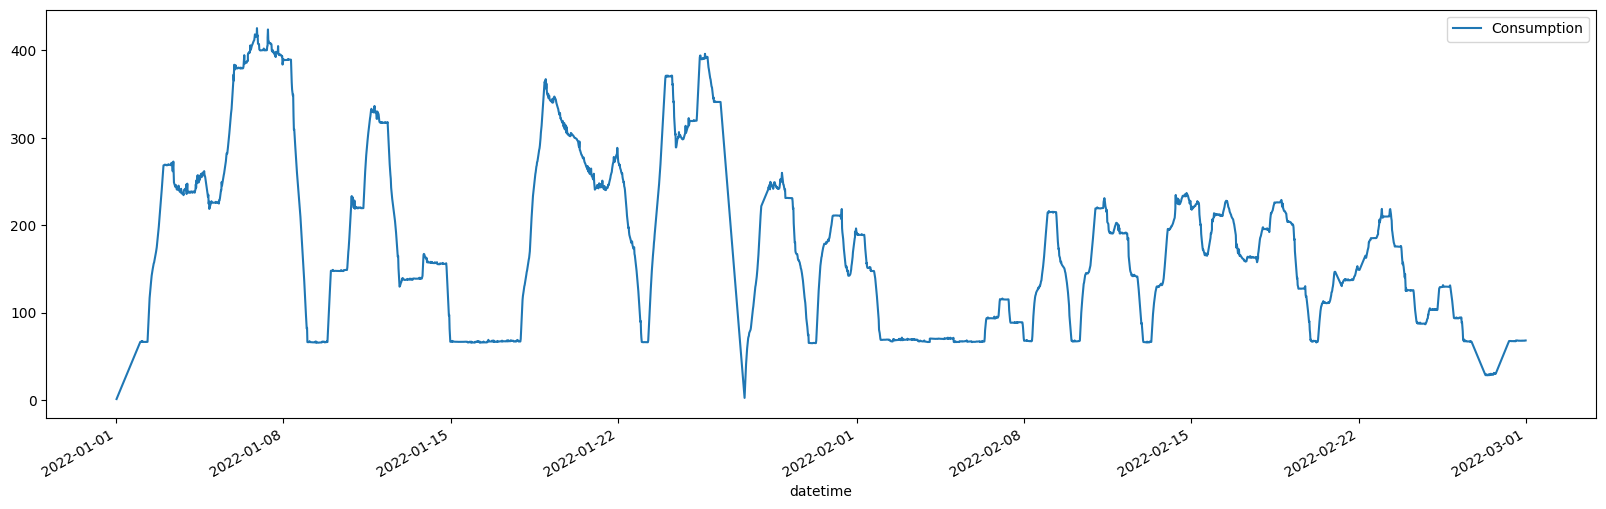

In [10]:
# Daily energy consumption
daily_df = df.rolling('1D',on='datetime').sum().loc[df['Consumption']>0.5]
daily_df.plot(x='datetime',y='Consumption',figsize=(20,6));

In [11]:

#   Nomalize Consumption to 0-1
daily_df['Consumption'] = daily_df['Consumption']/daily_df['Consumption'].max()
daily_df.describe()

,Consumption,datetime
count,3603.000000,3603
mean,0.407858,2022-01-30 11:41:14.496253184
min,0.002422,2022-01-01 00:22:28
25%,0.190799,2022-01-15 10:48:50
50%,0.375480,2022-01-31 03:25:02
75%,0.541593,2022-02-14 04:40:54
max,1.000000,2022-02-28 23:50:27
std,0.227126,NaN


# **TimeSeries Forecasting**

In [12]:


df_copy = ds = tf.data.Dataset.from_tensor_slices(daily_df['Consumption'])
df_copy

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.float64, name=None)>

In [13]:
for val in df_copy.take(10):
    print(val.numpy())

0.0024220249068813726
0.004547763271755898
0.006673501636630423
0.011023740547048423
0.01543982091124572
0.0180076376086384
0.020180405583355283
0.02240020316791452
0.024563565220662928
0.026745739117348285


In [68]:
window_size = 32
batch_size = 32
shuffle_buffer = 1000
split_time = 2500
train_time = daily_df["datetime"][:split_time]
x_train = daily_df['Consumption'][:split_time]
val_time = daily_df['datetime'][split_time:]
x_val = daily_df['Consumption'][split_time:]



In [69]:
def window_df(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)


In [70]:
X_train_ds = window_df(x_train, window_size, batch_size, shuffle_buffer)


In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, SimpleRNN 


In [72]:
model = Sequential()
model.add(LSTM(32, input_shape=[None, 1]))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [73]:

model.compile(loss='mean_squared_error', optimizer='adam')


**Additive Decompostion**

Epoch 1/100
78/78 [==============================] - 2s 5ms/step - loss: 0.0306
Epoch 2/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0044
Epoch 3/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 4/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 5/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 6/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 7/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 8/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 9/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 10/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 11/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 12/100
78/78 [==============================] - 0s 4ms/step - loss: 9.4357e-04
Epoch 13/100
78/78 [=============

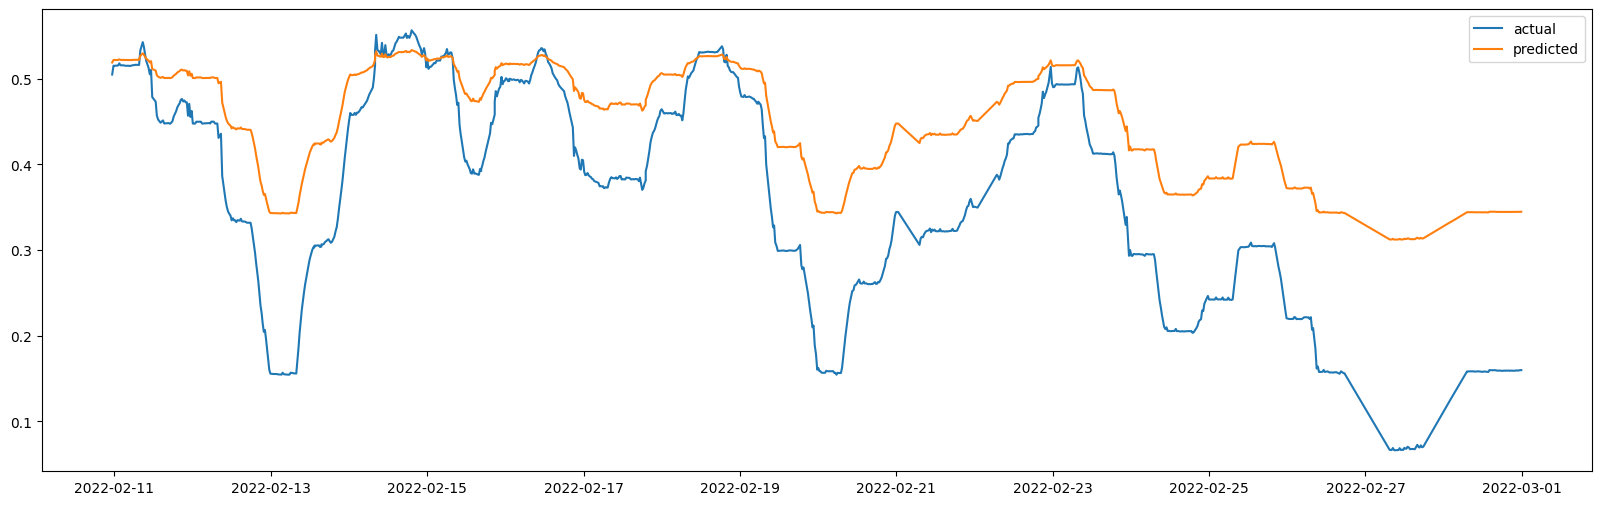

In [74]:
# fit model
model.fit(X_train_ds, epochs=100, verbose=1)
# draw plot to compare the actual and predicted values same day
plt.figure(figsize=(20,6))  
plt.plot(val_time, x_val, label='actual')
plt.plot(val_time, model.predict(x_val), label='predicted')
plt.legend()
plt.show()


